In [128]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("pendulumData.csv")

df['sys uncert'] = df['sys uncert'].apply(lambda x: 0 if isinstance(x, str) and '+' in x else x)
df['stat uncert'] = df['stat uncert'].apply(lambda x: 0 if isinstance(x, str) and '+' in x else x)
df['total uncert'] = df['total uncert'].apply(lambda x: 0 if isinstance(x, str) and '+' in x else x)

df['sys uncert'] = pd.to_numeric(df['sys uncert']).fillna(0)
df['stat uncert'] = pd.to_numeric(df['stat uncert']).fillna(0)
df['total uncert'] = pd.to_numeric(df['total uncert']).fillna(df['stat uncert'].add(df['sys uncert']))

df = df[df['g (m/s2)'].notna()]
df = df[df['g (m/s2)'] < 100]
df = df[df['total uncert'].notna()]
print(df)

g = df['g (m/s2)'].to_numpy()
uncert = df['total uncert'].to_numpy()

mean_g = np.mean(g)
mean_uncert = np.mean(uncert)
std_g = np.std(g)
std_uncert = np.std(uncert)
print("mean g: ", mean_g)
print("mean uncert: ", mean_uncert)

               label  g (m/s2)  stat uncert  sys uncert  total uncert
0    20.Sep.X.B01.01     9.830       0.0075       0.000        0.0075
1    20.Sep.X.B01.02     9.060       0.1400       0.230        0.3700
2    20.Sep.X.B01.03     9.790       0.0200       0.020        0.0400
3    20.Sep.X.B01.04     9.882       0.0160       0.130        0.1460
5    20.Sep.X.B02.01     9.807       0.0010       0.008        0.0090
..               ...       ...          ...         ...           ...
229  23.Feb.A.B02.05    10.440       0.0000       0.000        0.3600
230  23.Feb.A.B02.06     8.500       0.0000       0.000        0.3000
231  23.Feb.A.B02.07    10.900       0.0000       0.000        1.3000
232  23.Feb.A.B02.08     9.550       0.0000       0.000        0.1300
233  23.Feb.A.B02.09    10.110       0.0000       0.000        0.2300

[233 rows x 5 columns]
mean g:  9.817732353472103
mean uncert:  0.3707510225150215


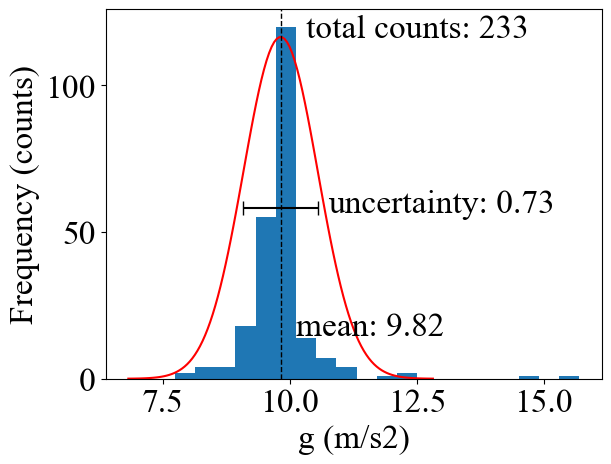

In [129]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def lorentzian(x, mu, sig):
    return 1 / (np.pi * sig * (1 + np.power((x - mu) / sig, 2)))

x_values = np.linspace(mean_g - 3, mean_g + 3, 120)
bin_width = 2
N = g.size / bin_width
plt.plot(x_values, N * gaussian(x_values, mean_g, std_g), color='red')
data = plt.hist(g, bins=20)

# Set axes
plt.xlabel('g (m/s2)')
plt.ylabel('Frequency (counts)')

# Annotate with mean and standard deviation
plt.annotate('mean: ' + str(round(mean_g, 2)), (mean_g + 0.3, 15), color='black')

# Annotate total counts
plt.annotate('total counts: ' + str(g.size), (mean_g + 0.5, N), color='black')

# Annotate uncertainty
plt.annotate('uncertainty: ' + str(round(std_g, 2)), (mean_g + std_g + 0.2, N / 2 - 1.5), color='black')

# Annotate the uncertainty with a horizontal error bar
plt.errorbar(mean_g, N / 2, xerr=std_g, color='black', capsize=5, capthick=1)

# Vertical line at mean
plt.axvline(mean_g, color='black', linestyle='--', linewidth=1)

# Set title
# plt.title('Measurements of g (m/s2)')

# plt.show()
# change font size
plt.rcParams.update({'font.size': 24, 'font.family': 'times new roman'})

plt.savefig('g.pdf', bbox_inches='tight')

[  2.   4.   4.  18.  55. 120.  14.   7.   4.   1.   2.   1.   1.]


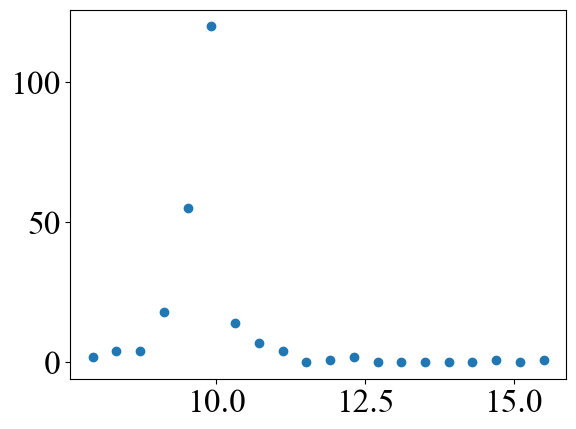

In [130]:
bin_counts = data[0]
bin_centers = []
for i in range(len(data[1]) - 1):
    bin_centers.append((data[1][i] + data[1][i + 1]) / 2)

plt.plot(bin_centers, bin_counts, 'o')

i = 0
while i < len(bin_centers):
    if bin_counts[i] == 0.0:
        bin_centers = np.delete(bin_centers, i)
        bin_counts = np.delete(bin_counts, i)
    else:
        i += 1
        
bin_uncertainties = np.sqrt(bin_counts)
bin_centers = np.array(bin_centers)
bin_counts = np.array(bin_counts)
print(bin_counts)

In [131]:
import scipy.optimize as opt
from scipy.special import factorial

def scaled_gaussian(x, mu, sig):
    return g.size / bin_width * gaussian(x, mu, sig)

FUNC_TO_FIT = scaled_gaussian

popt, pcov = opt.curve_fit(f=FUNC_TO_FIT, xdata=bin_centers, ydata=bin_counts, sigma=bin_uncertainties, p0=[9.8,0.2], absolute_sigma=True)
uncert = np.sqrt(np.diag(pcov))
print(popt, uncert)

[9.81338644 0.25885914] [0.01910795 0.01234062]


<ErrorbarContainer object of 3 artists>

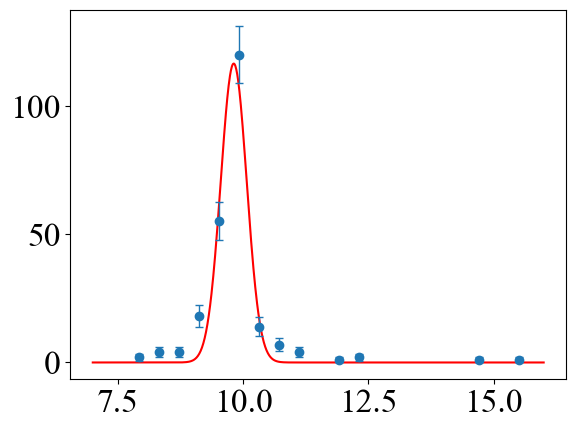

In [132]:
x = np.linspace(7, 16, 1000)
plt.plot(x, FUNC_TO_FIT(x, *popt), color='red')
plt.errorbar(bin_centers, bin_counts, yerr=bin_uncertainties, linewidth=1, ls='none', fmt='o', capsize=3)

In [133]:
from scipy import stats

def chisq(func,popt,x,y,sig):
    '''
    Inputs:
    func = function to generate expected value
    x = x data
    y = y data
    sig = sigma data
    Outputs:
    chi2 = chi-squared value
    '''
    expected_vals = func(x, *popt) # Again, better off using *popt
    return np.sum((y-expected_vals)**2/expected_vals**2)

# chi2 = chisq(FUNC_TO_FIT, popt,bin_centers, bin_counts, bin_uncertainties)
# chi2 = stats.chisquare(bin_counts, FUNC_TO_FIT(bin_centers, *popt), ddof=2)

f_exp = [FUNC_TO_FIT(x, *popt) for x in bin_centers]
print(bin_counts)
print(f_exp)
params = 2
dof = len(bin_centers) - params
chi2 = stats.chisquare(bin_counts, f_exp, ddof=2)
print(chi2)

# chi2_prob = 1 - stats.chi2.cdf(chi2, dof)
# print(chi2_prob)

[  2.   4.   4.  18.  55. 120.  14.   7.   4.   1.   2.   1.   1.]
[3.649578503697804e-10, 8.201927092789741e-06, 0.017232785409416813, 3.385021538662032, 62.16325882956, 106.72655518827563, 17.130797880584264, 0.2570686228979541, 0.00036065082665797516, 5.800451456049483e-13, 6.649650200084316e-19, 3.672102717093711e-76, 1.75826585256656e-103]


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.2283826810523609